,Column,Data Type,Missing Values
0,Age,int64,0
1,Sex,int64,0
2,Dx Type,int64,0
3,Months,int64,0
4,Stroke,int64,0
5,Fracture,int64,0
6,Care needs,int64,0
7,JCS,int64,0
8,KE-MMT,int64,0
9,LE-BRS,int64,0


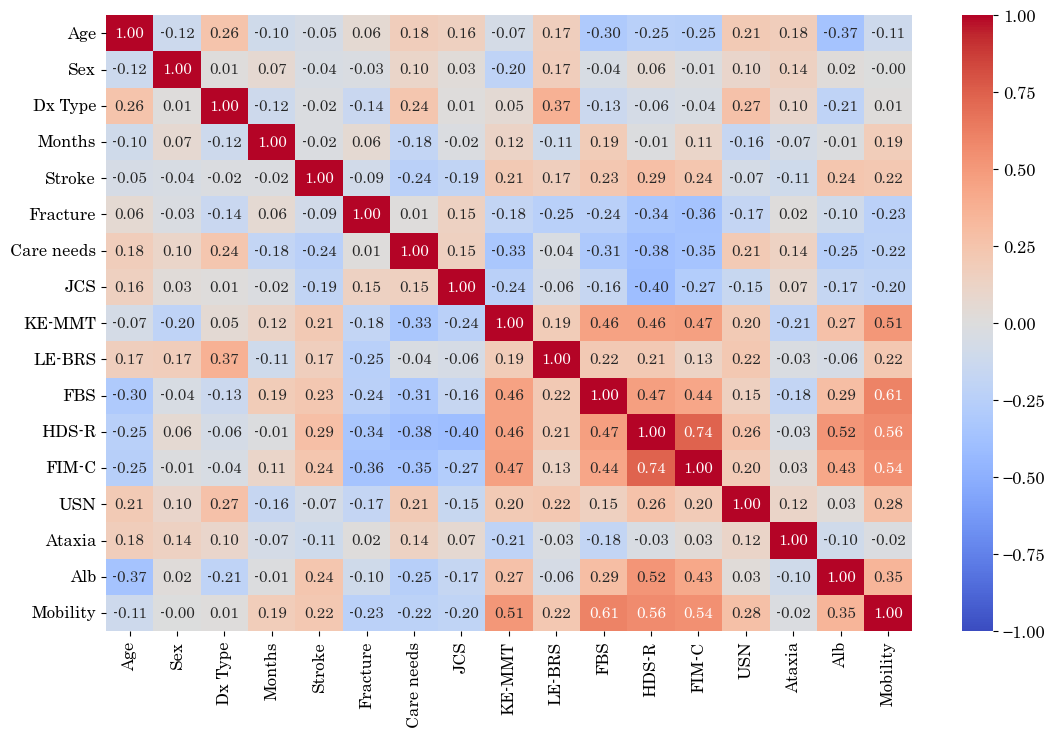

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
import optuna
optuna.logging.disable_default_handler()
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance
import dtreeviz
from sklearn.tree import export_graphviz
import graphviz

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Load dataset
data = pd.read_csv('data.csv')
summary_data = pd.DataFrame({
    'Column': data.columns,
    'Data Type': data.dtypes.values,
    'Missing Values': data.isnull().sum().values})
display(summary_data)

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=SEED, stratify=data['Mobility'])

# Separate features and target in training and testing sets
X_train = train_data.drop(columns=['Mobility'])
y_train = train_data['Mobility']
X_test = test_data.drop(columns=['Mobility'])
y_test = test_data['Mobility']

# Plot correlation heatmap for training data
plt.rcParams['font.family'] = 'Century'
plt.rcParams.update({
    'font.size': 11,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})
plt.figure(figsize=(13, 8))
corr_matrix = train_data.corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)
heatmap_filename = 'correlation_heatmap3.pdf'
#plt.savefig(heatmap_filename, dpi=300, bbox_inches='tight') #Save pdf
plt.show()

In [2]:
# Remove highly correlated feature
X_train = X_train.drop(columns=['FIM-C'])
X_test = X_test.drop(columns=['FIM-C'])

# Hyperparameter tuning for Random Forest, LightGBM
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 250),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'random_state': SEED
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    auc_scores = []
    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_fold_train, y_fold_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model = RandomForestClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        y_pred_proba = model.predict_proba(X_fold_valid)
        auc = roc_auc_score(y_fold_valid, y_pred_proba, multi_class='ovr')
        auc_scores.append(auc)
    return np.mean(auc_scores)

def lgb_objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': y_train.nunique(),
        'metric': 'multi_logloss',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'subsample': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'random_state': SEED,
        'n_estimators': 10000,
        'verbosity' : -1
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    auc_scores = []
    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_fold_train, y_fold_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model = LGBMClassifier(**params)
        model.fit(
            X_fold_train, y_fold_train,
            eval_set=[(X_fold_valid, y_fold_valid)],
            callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)] 
        )
        y_pred_proba = model.predict_proba(X_fold_valid)
        auc = roc_auc_score(y_fold_valid, y_pred_proba, multi_class='ovr', average='macro')
        auc_scores.append(auc)
    return np.mean(auc_scores)

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=100)
rf_best_params = rf_study.best_params
rf_best_params['random_state'] = SEED

lgb_study = optuna.create_study(direction='maximize')
lgb_study.optimize(lgb_objective, n_trials=100)
lgb_best_params = lgb_study.best_params
lgb_best_params.update({
    'objective': 'multiclass',
    'num_class': y_train.nunique(),
    'metric': 'multi_logloss',
    'random_state': SEED,
    'verbose': -1
})

# Evaluate model performance on test data
models = {
    'Logistic Regression': OneVsRestClassifier(LogisticRegression(random_state=SEED, max_iter=1000)),
    'Decision Tree': DecisionTreeClassifier(random_state=SEED),
    'Random Forest': RandomForestClassifier(**rf_best_params),
    'LightGBM': LGBMClassifier(**lgb_best_params)
}
results = []
classes = np.unique(y_test)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=classes, zero_division=0)
    result = {
        'Model': name,
        'AUC': auc,
        'Accuracy': acc
    }
    for idx, cls in enumerate(classes):
        result[f'Precision_Class_{cls}'] = precision[idx]
        result[f'Recall_Class_{cls}'] = recall[idx]
        result[f'F1_Score_Class_{cls}'] = f1[idx]    
    results.append(result)
results_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
display(results_df)

,Model,AUC,Accuracy,Precision_Class_0,Recall_Class_0,F1_Score_Class_0,Precision_Class_1,Recall_Class_1,F1_Score_Class_1,Precision_Class_2,Recall_Class_2,F1_Score_Class_2
2,Random Forest,0.950956,0.877193,0.949367,0.949367,0.949367,0.703704,0.76,0.730769,0.750000,0.6,0.666667
3,LightGBM,0.943990,0.894737,0.950617,0.974684,0.962500,0.760000,0.76,0.760000,0.750000,0.6,0.666667
0,Logistic Regression,0.903432,0.815789,0.890244,0.924051,0.906832,0.576923,0.60,0.588235,0.833333,0.5,0.625000
1,Decision Tree,0.769022,0.789474,0.958904,0.886076,0.921053,0.516129,0.64,0.571429,0.400000,0.4,0.400000


In [3]:
#Calculate Permutation Importances
macro_ovr_roc_auc_scorer = make_scorer(
    lambda y_true, y_pred_proba: roc_auc_score(y_true, y_pred_proba, average='macro', multi_class='ovr'),
    response_method='predict_proba'
)

perm_importance = permutation_importance(
    estimator=models['Random Forest'],
    X=X_test,
    y=y_test,
    scoring=macro_ovr_roc_auc_scorer,
    n_repeats=10,
    random_state=SEED
)

feature_names = X_test.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values(by='Importance_Mean', ascending=False)
print("Permutation Importances")
display(importance_df)

Permutation Importances


,Feature,Importance_Mean,Importance_Std
9,FBS,0.073759,0.015690
13,KE-MMT,0.043846,0.010841
10,Months,0.022549,0.007292
14,HDS-R,0.020470,0.009252
2,Dx Type,0.015604,0.006065
5,USN,0.010113,0.005146
1,Sex,0.005686,0.002587
7,Alb,0.004600,0.002654
0,Age,0.003941,0.004204
12,LE-BRS,0.003426,0.003083


In [4]:
#Knowledge Distillation
def generate_synthetic_samples(X_train, model, num_samples, alteration_prob=0.5, seed=None):
    rng = np.random.default_rng(seed)
    X_array = X_train.values
    X_synthetic = []
    for _ in range(num_samples):
        sample = X_array[rng.choice(len(X_array))].copy()
        for i in range(X_array.shape[1]):
            if rng.random() <= alteration_prob:
                sample[i] = rng.choice(X_array[:, i])
        X_synthetic.append(sample)
    X_synthetic = pd.DataFrame(np.array(X_synthetic), columns=X_train.columns)
    y_synthetic = model.predict(X_synthetic)
    return X_synthetic, y_synthetic

classes = np.unique(y_test)
num_samples = 50 * len(X_train)

X_synthetic, y_synthetic = generate_synthetic_samples(
    X_train, models['Random Forest'], num_samples, alteration_prob=0.5, seed=SEED
)

distilled_tree_model = DecisionTreeClassifier(ccp_alpha=0.0005, max_depth=5, random_state=SEED)
distilled_tree_model.fit(X_synthetic, y_synthetic)

# Evaluate Distilled tree
y_pred = distilled_tree_model.predict(X_test)
y_pred_proba = distilled_tree_model.predict_proba(X_test)
distilled_tree_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
distilled_tree_acc = accuracy_score(y_test, y_pred)
distilled_tree_precision, distilled_tree_recall, distilled_tree_f1, _ = precision_recall_fscore_support(
    y_test, y_pred, labels=classes, zero_division=0
)

distilled_tree_results = {
    "Model": ["Distilled Tree"],
    "AUC": [distilled_tree_auc],
    "Accuracy": [distilled_tree_acc]
}
for idx, cls in enumerate(classes):
    distilled_tree_results[f'Precision_Class_{cls}'] = [distilled_tree_precision[idx]]
    distilled_tree_results[f'Recall_Class_{cls}'] = [distilled_tree_recall[idx]]
    distilled_tree_results[f'F1_Score_Class_{cls}'] = [distilled_tree_f1[idx]]
distilled_tree_results_df = pd.DataFrame(distilled_tree_results)
results_df = pd.concat([results_df, distilled_tree_results_df], ignore_index=True)
results_df = results_df.sort_values(by='AUC', ascending=False).reset_index(drop=True)
display(results_df)

# Retrieve hyperparameters for various models
print('Random Forest')
print(models['Random Forest'].get_params())

print('LightGBM')
print(models['LightGBM'].get_params())

print('distilled_tree')
print(distilled_tree_model.get_params())

print('Logistic Regression')
print(models['Logistic Regression'].get_params())

print('Decision Tree')
print(models['Decision Tree'].get_params())

,Model,AUC,Accuracy,Precision_Class_0,Recall_Class_0,F1_Score_Class_0,Precision_Class_1,Recall_Class_1,F1_Score_Class_1,Precision_Class_2,Recall_Class_2,F1_Score_Class_2
0,Random Forest,0.950956,0.877193,0.949367,0.949367,0.949367,0.703704,0.76,0.730769,0.750000,0.6,0.666667
1,LightGBM,0.943990,0.894737,0.950617,0.974684,0.962500,0.760000,0.76,0.760000,0.750000,0.6,0.666667
2,Distilled Tree,0.932790,0.824561,0.847826,0.987342,0.912281,0.736842,0.56,0.636364,0.666667,0.2,0.307692
3,Logistic Regression,0.903432,0.815789,0.890244,0.924051,0.906832,0.576923,0.60,0.588235,0.833333,0.5,0.625000
4,Decision Tree,0.769022,0.789474,0.958904,0.886076,0.921053,0.516129,0.64,0.571429,0.400000,0.4,0.400000


Random Forest
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 190, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
LightGBM
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.030406683596093803, 'max_depth': 10, 'min_child_samples': 4, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 186, 'objective': 'multiclass', 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'lambda_l1': 0.004335551811007204, 'lambda_l2': 0.005459237324334797, 'feature_fraction': 0.5846578731787533, 'bagging_fraction

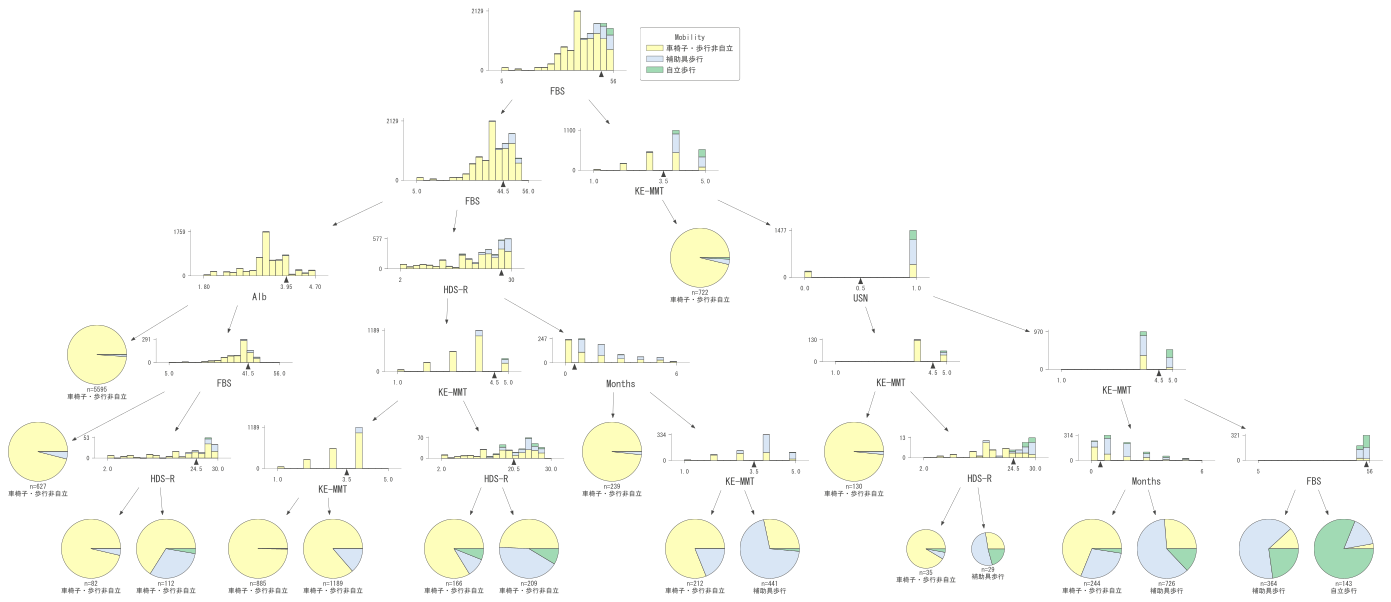

In [5]:
# Visualize Distilled_tree
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
# Suppress the warning about missing feature names.
# dtreeviz internally converts the DataFrame to a NumPy array, which results in the loss of feature name information.
# This warning is harmless and does not affect the functionality or the correctness of the visualization.

viz = dtreeviz.model(
    distilled_tree_model,
    X_synthetic,
    y_synthetic,
    target_name='Mobility',
    feature_names= X_synthetic.columns,
    class_names = {0: "車椅子・歩行非自立", 1: "補助具歩行", 2: "自立歩行"} 
)
viz.view(fontname = 'MS gothic',show_root_edge_labels = False, label_fontsize = 13)

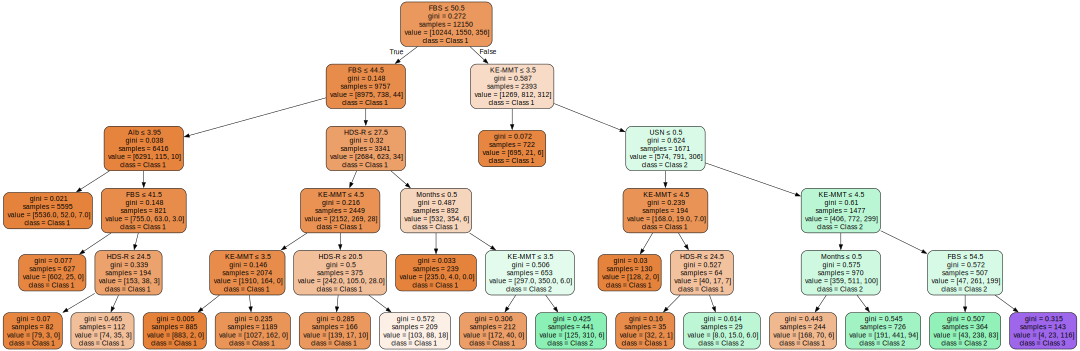

In [6]:
# Visualize Distilled_tree
dot_data = export_graphviz(distilled_tree_model, out_file=None, 
                           feature_names=X_train.columns.tolist(), 
                           class_names=['Class 1', 'Class 2', 'Class 3'],
                           filled=True, rounded=True, special_characters=True)
dot_lines = dot_data.split('\n')
dot_lines.insert(1, 'graph [size="15,15", ratio="compress"];')
dot_data_modified = "\n".join(dot_lines)
graphviz.Source(dot_data_modified)